In [1]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.patches import Patch

import plotnine
from plotnine import *

dpi = 300

In [2]:
from imp import load_source
nanospot=load_source('nanospot', '/home/jovyan/python/Nanospot/nanospot/nanospot.py')

In [3]:
result_path='/lustre/scratch117/cellgen/team283/tl7/project/nanostring-covid/data/SpaceJam/LungAtlas_model/results/20220316_SpaceJam_UKCIC36Donor/'
result_directory='LocationModelWTAMultiExperimentHierarchicalGeneLevel_5experiments_62clusters_80locations_7837genes_control_geneE-6_cellE6/'
sp_adata=sc.read_h5ad(f"{result_path}{result_directory}sp.h5ad")
sp_adata.obs['area mm2']=np.array(sp_adata.obs['area um2'] * 1e-6)


abundance_df=nanospot.plot_C2L_results()
abundance_df.create_scatter_df(sp_adata, background='Control')

/software/team283/tl7/conda_env/spacejam/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
result_path='/lustre/scratch117/cellgen/team283/tl7/project/nanostring-covid/data/SpaceJam/LungAtlas_model/results/20220411_SpaceJam_UKCIC33Donor/'

result_directory='LocationModelWTAMultiExperimentHierarchicalGeneLevel_23experiments_62clusters_94locations_10276genes_new_PRESPRES-likeACFF_cell1e6/'
sp_adata=sc.read_h5ad(f"{result_path}{result_directory}sp.h5ad")

result_directory='LocationModelWTAMultiExperimentHierarchicalGeneLevel_28experiments_62clusters_139locations_10276genes_new_MDADODAD-likeODADBRON_cell1e6/'

    
sp_adata=sp_adata.concatenate(sc.read_h5ad(f"{result_path}{result_directory}sp.h5ad"))
sp_adata.obs['area mm2']=np.array(sp_adata.obs['area'] * 1e-6, dtype='float32')

abundance_df.create_scatter_df(sp_adata, background='COVID-19')

### Figure 4B

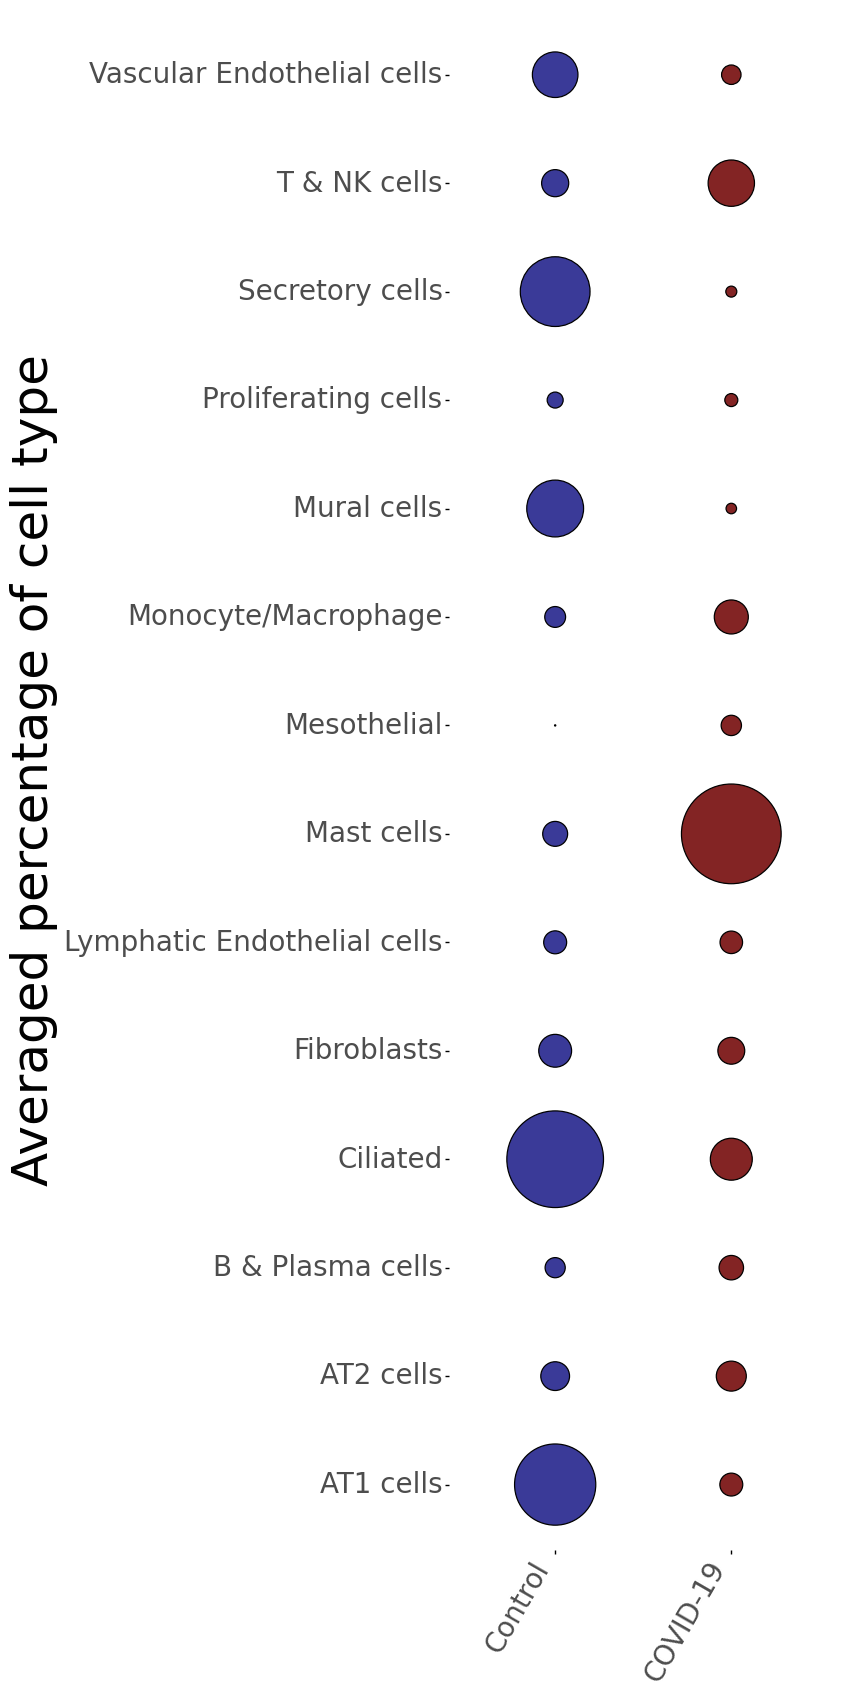

<ggplot: (8776126061113)>

In [5]:
plotnine.options.figure_size=(5,20)
plotnine.dpi = dpi


plot_abundance_disease = pd.read_csv("../data/fig4_celltype_abundance_percentage_diseases.csv", sep=",", index_col = 0)

p1 = (
        ggplot() +
        geom_point(data = plot_abundance_disease, mapping = aes(x = "Background", y = "Celltype", fill = "Background", size = "Abundance" )) +
        theme_bw() +
        theme(axis_text_x = element_text(angle = 60, vjust = 1, hjust=1, size=20), 
              axis_text_y = element_text(size=20),
              title = element_text(size=36), 
              axis_title_x = element_text(size=20), 
              axis_title_y = element_text(size=36), 
              panel_grid_major_x = element_blank(),
              panel_grid_major_y = element_blank(),
              strip_background_x= element_blank(),
              strip_text_x = element_blank(),
              panel_border = element_blank(),
              legend_position = "none" ) + 
        scale_size_continuous(range=[0,40]) + 
        scale_x_discrete(limits=["Control", "COVID-19"]) +
        scale_fill_manual(breaks = ["Control", "COVID-19"], values=["#3A3A98", "#832424"]) +
        ylab("Averaged percentage of cell type") + xlab("")
)

p1

### Figure 4C

In [6]:
from scipy.stats import ttest_ind
from statsmodels.stats import multitest
from re import sub


cell_abbreviations=pd.read_csv("/home/jovyan/projects/nanostring-covid/data/cell_altname_v1.csv", index_col=0, sep=',')
cell_abbreviations.index = cell_abbreviations.cell_states

cell_abbreviations=cell_abbreviations['alt_name'].to_dict()

abundance_df.abundance_df["Celltype"] = [cell_abbreviations.get(cell) for cell in abundance_df.abundance_df.Celltype]

## Perform t-test
tmp_df=abundance_df.abundance_df
p_value_result=[]

for cell in tmp_df['Celltype'].unique():
    tmp_df_celltype=tmp_df[tmp_df.Celltype == cell]
    tstat, p = ttest_ind(
        np.array(tmp_df_celltype[tmp_df_celltype['Background']=='Control'].Abundance), 
        np.array(tmp_df_celltype[tmp_df_celltype['Background']=='COVID-19'].Abundance)
    )
    p_value_result.append(round(p, 5))

## multiple testing p_value adjust
p_value_result = multitest.multipletests(p_value_result, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)


## add pvalue results to title
p_val_df = pd.DataFrame(index = np.array(tmp_df['Celltype'].unique()),
                      data = {'p_value': [ "p = " + sub("^(.{5}).*",  "\\1", pval ) for pval in p_value_result[1].astype('str') ]}
)
p_val_df = p_val_df.to_dict()

abundance_df.abundance_df.Celltype = [ cell + "\n" + p_val_df.get("p_value").get(cell) for cell in abundance_df.abundance_df.Celltype]

In [7]:
abundance_df.plot_scatter(col_wrap = 8,  palette=[ "#3A3A98", "#832424"], dpi = dpi)

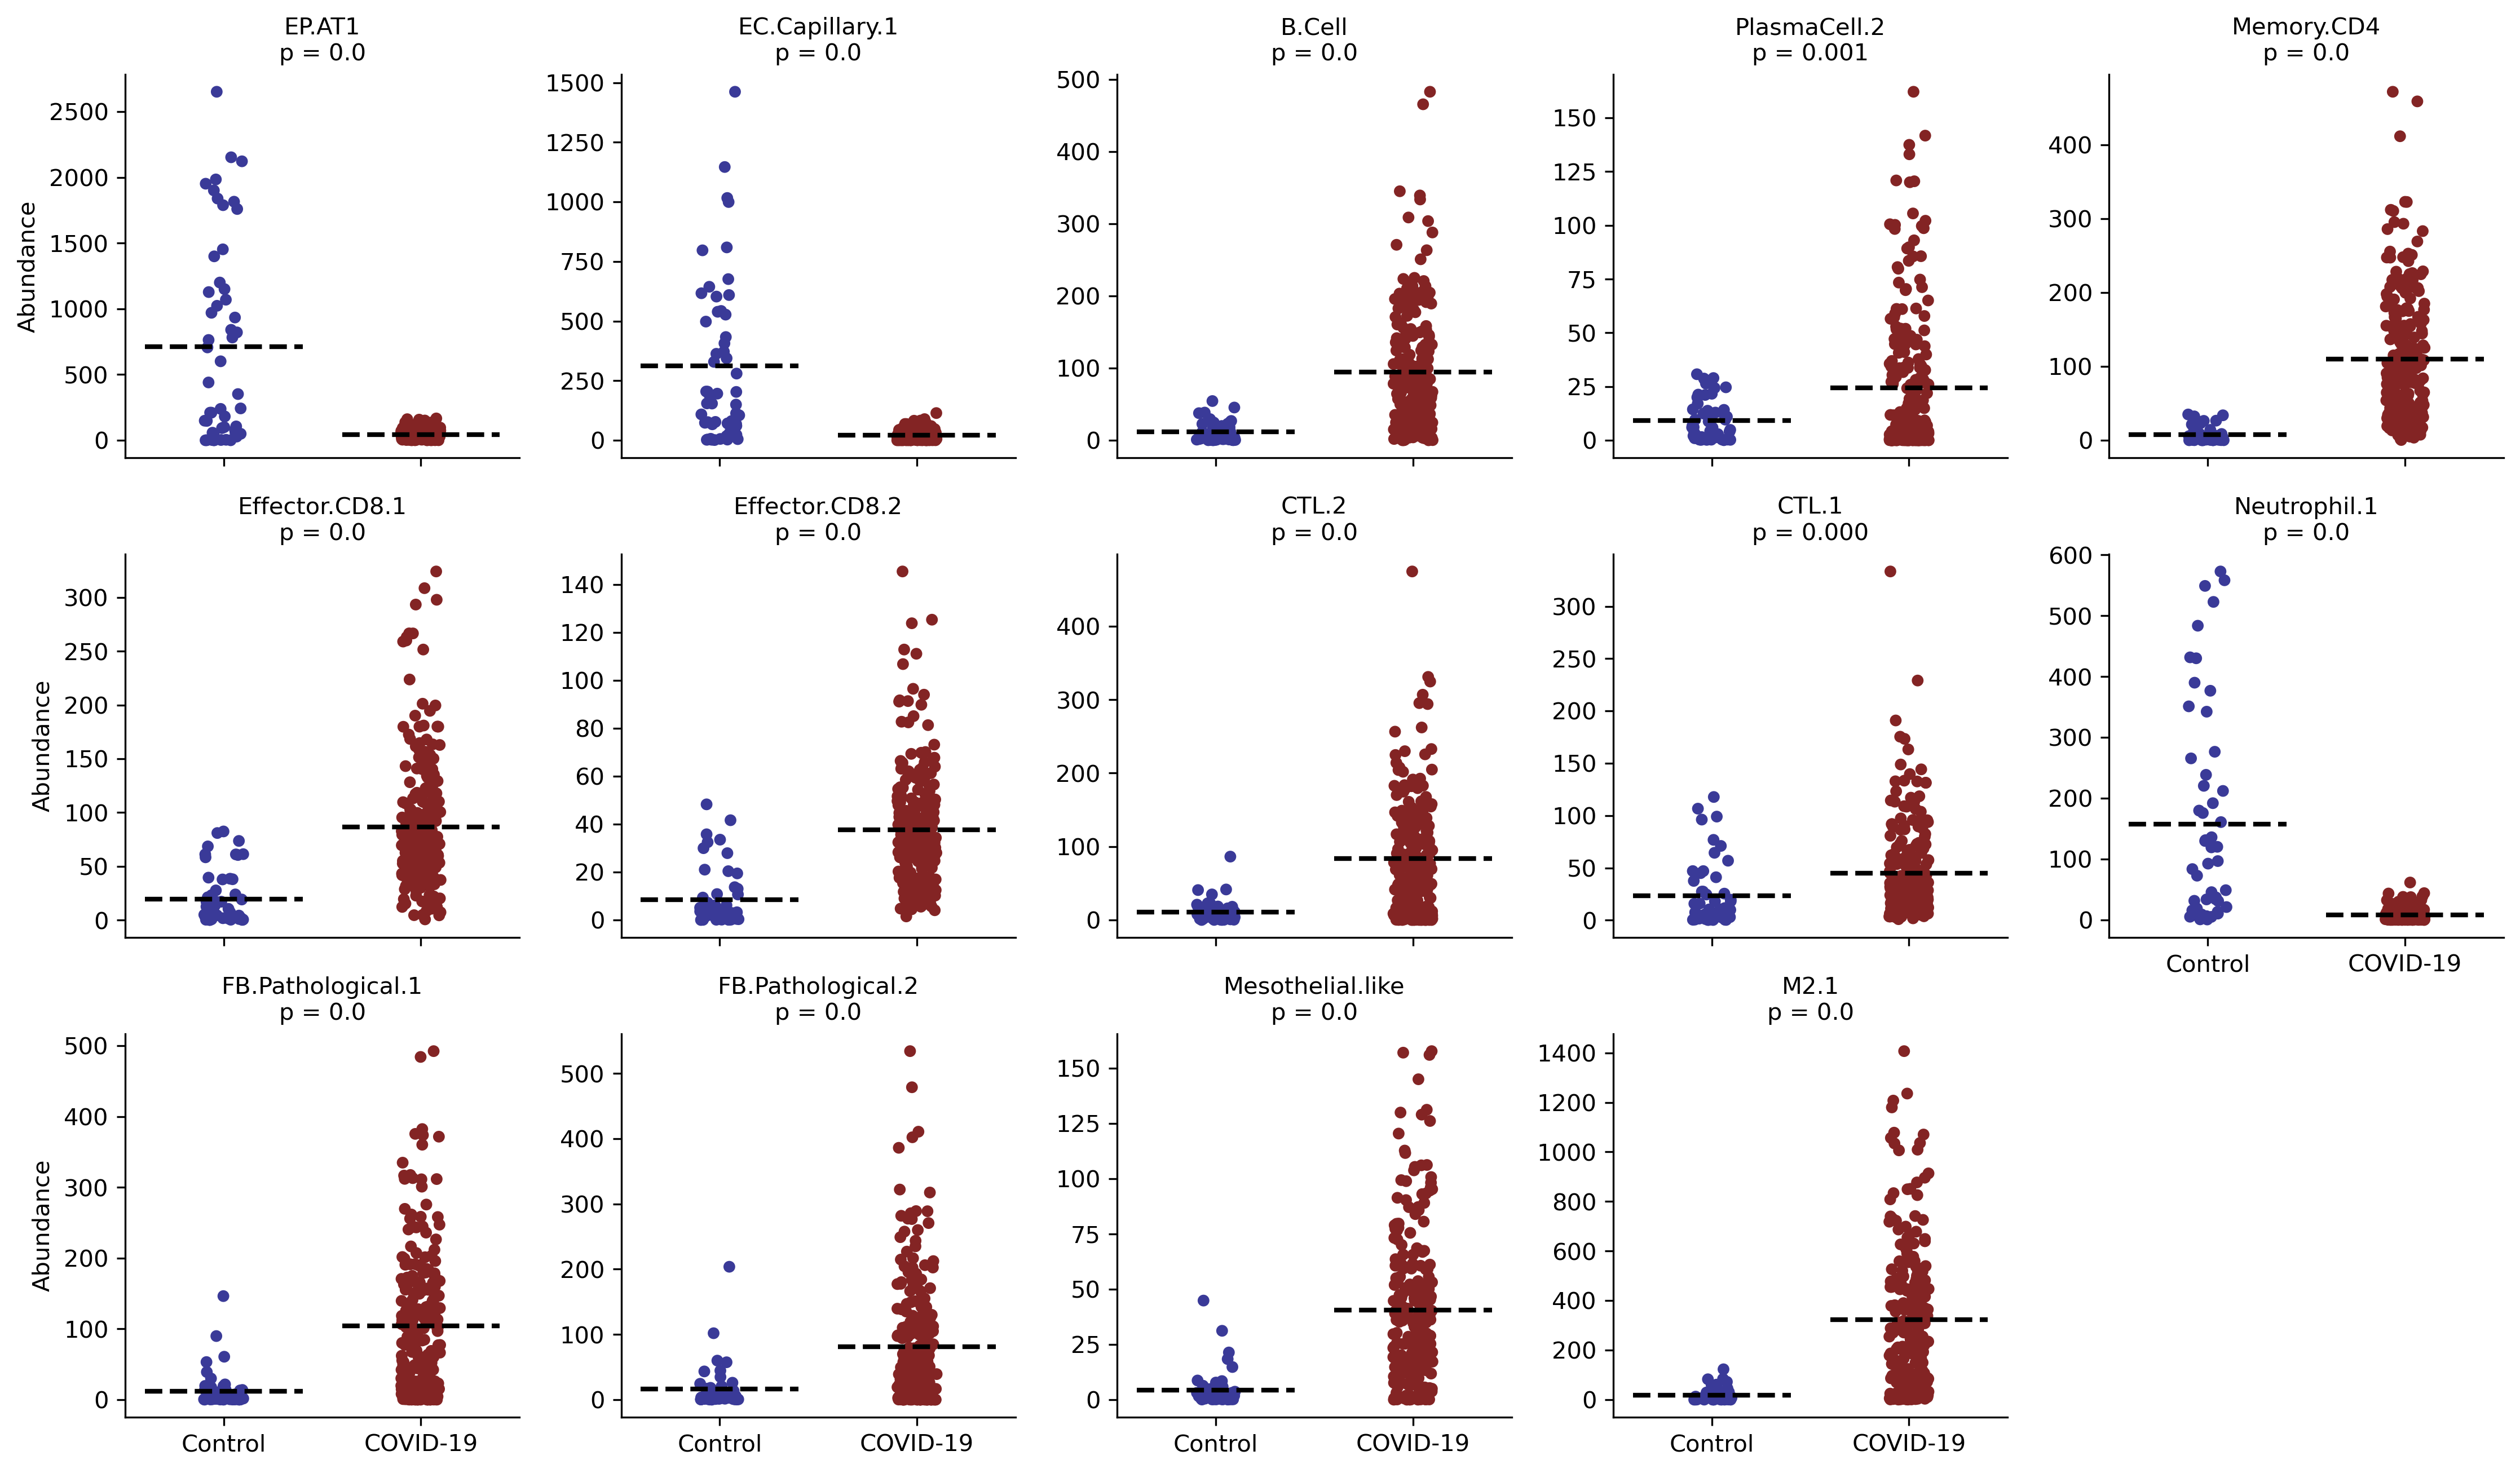

In [8]:
abundance_df.plot_scatter(cell_type = ["AT1","AT 2.1", "Capillary.1", "B.Cell", "PlasmaCell.2", "CD4", "CD8", "CTL", "Neutrophil.1", "Pathological.1", "Pathological.2", "Mesothelial", "M2.1"], col_wrap = 5,  palette=[ "#3A3A98", "#832424"], set_ylabels="Abundance", dpi = dpi )

/software/team283/tl7/conda_env/spacejam/lib/python3.7/site-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


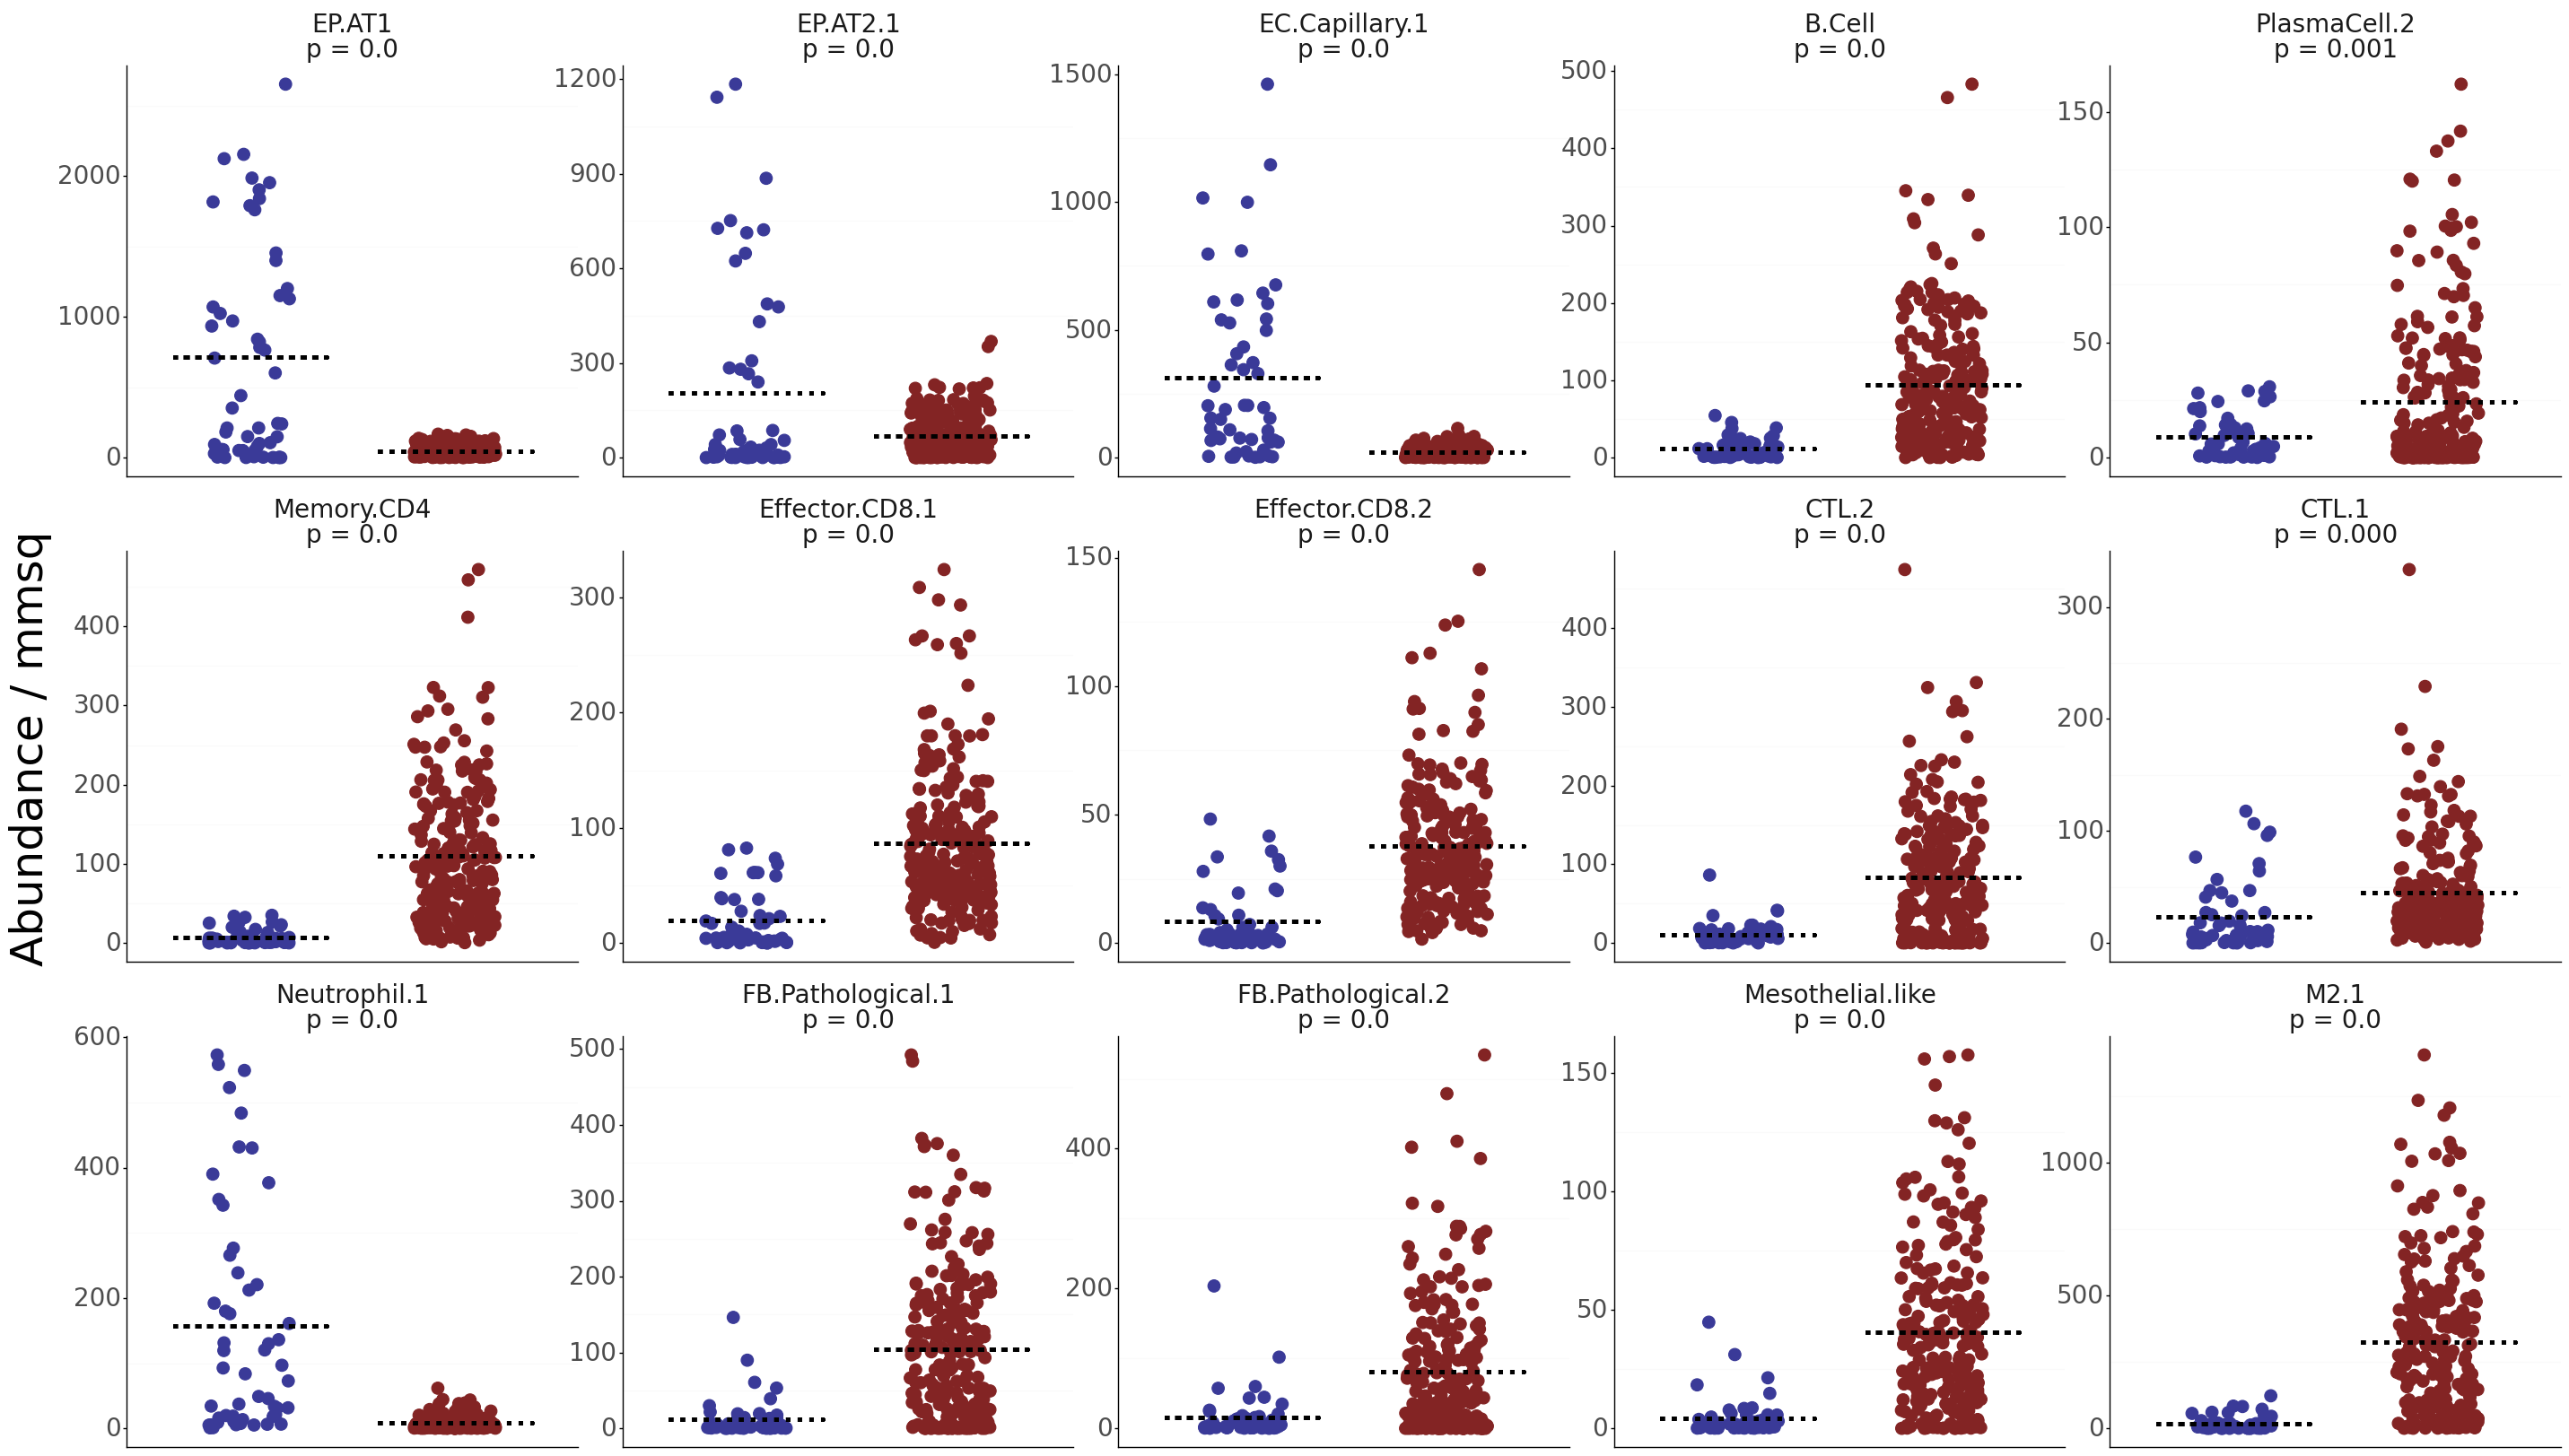

<ggplot: (8776126515449)>

In [9]:
plotnine.options.figure_size=(35,20)
plotnine.dpi = dpi

select_cell_type = ["AT1","AT2.1", "Capillary.1", "B.Cell", "PlasmaCell.2", "CD4", "CD8", "CTL", "Neutrophil.1", "Pathological.1", "Pathological.2", "Mesothelial", "M2.1"]

plot_abundance_celltype = pd.DataFrame()

for cell_type in select_cell_type:
    plot_abundance_celltype = plot_abundance_celltype.append( abundance_df.abundance_df[ [ cell_type in c for c in abundance_df.abundance_df.Celltype ] ] )

plot_abundance_celltype.Celltype = pd.Categorical(plot_abundance_celltype.Celltype, ordered=True, categories=plot_abundance_celltype.Celltype.unique() )
    
p2 = (
    ggplot() + 
    geom_jitter(data = plot_abundance_celltype, mapping = aes(x = "Background", y = "Abundance", colour = "Background"), width = .2, size = 5 ) + 
    geom_boxplot(data = plot_abundance_celltype.groupby(["Background", "Celltype"]).mean().reset_index(), mapping = aes(x = "Background", y = "Abundance"), 
                 colour = "black", linetype = "dotted", size = 2, fatten = 1, fill = None, coef = 0, outlier_alpha = 0) + 
    theme_bw() +
    theme(axis_text_x = element_blank(), 
          axis_text_y = element_text(size=20),
          axis_title_x = element_blank(), 
          axis_title_y = element_text(size=36),
          axis_ticks_major_x = element_blank(),
          panel_grid_major_x = element_blank(),
          panel_grid_major_y = element_blank(),
          strip_background_x= element_blank(),
          strip_text_x=element_text(size = 20),
          panel_border = element_blank(),
          panel_spacing_x = .5,
          panel_spacing_y = .2,
          axis_line_x = element_line(),
          axis_line_y = element_line(),
          legend_position = "none" ) + 
    scale_x_discrete(limits=["Control", "COVID-19"]) +
    scale_colour_manual(breaks = ["Control", "COVID-19"], values=["#3A3A98", "#832424"]) +
    facet_wrap(facets="~Celltype", scales="free_y", ncol = 5) +
    ylab("Abundance / mmsq")
)

p2

### Figure 4E

In [10]:
case = 300 ## Finalise this bit afterwards
result_path='/lustre/scratch117/cellgen/team283/tl7/project/nanostring-covid/data/SpaceJam/LungAtlas_model/results/20220411_SpaceJam_UKCIC33Donor/LocationModelWTAMultiExperimentHierarchicalGeneLevel_'

if case == 100:
    # PRES and ACFF
    result_directory='26experiments_62clusters_141locations_10276genes_33DonorPRESEDADACFFgeneE-6_cellE6/'
    sp_adata=sc.read_h5ad(f"{result_path}{result_directory}sp.h5ad")

    # DADs and BRON
    result_directory='20experiments_62clusters_92locations_10276genes_33DonorNoPRESEDADACFFgeneE-6_cellE6/'

elif case == 200:
    result_directory='23experiments_62clusters_94locations_10276genes_PRESPRES-likeACFF_cell1e6/'
    sp_adata=sc.read_h5ad(f"{result_path}{result_directory}sp.h5ad")

    result_directory='28experiments_62clusters_139locations_10276genes_MDADODAD-likeODADBRON_cell1e6/'

elif case == 300:
    result_directory='23experiments_62clusters_94locations_10276genes_new_PRESPRES-likeACFF_cell1e6/'
    sp_adata=sc.read_h5ad(f"{result_path}{result_directory}sp.h5ad")

    result_directory='28experiments_62clusters_139locations_10276genes_new_MDADODAD-likeODADBRON_cell1e6/'
    
    
sp_adata=sp_adata.concatenate(sc.read_h5ad(f"{result_path}{result_directory}sp.h5ad"))
sp_adata.obs['area mm2']=np.array(sp_adata.obs['area'] * 1e-6, dtype='float32')

abundance_df=nanospot.plot_C2L_results()

[abundance_df.create_scatter_df(sp_adata[sp_adata.obs.Pathology == patho_gp], background=patho_gp) for patho_gp in ["PRES", "EDAD", "MDAD", "ODAD", "ACFF", "BRON"]]

/software/team283/tl7/conda_env/spacejam/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[None, None, None, None, None, None]

In [11]:
cell_abbreviations=pd.read_csv("/home/jovyan/projects/nanostring-covid/data/cell_altname_v1.csv", index_col=0, sep=',')
cell_abbreviations.index = cell_abbreviations.cell_states

cell_abbreviations=cell_abbreviations['alt_name'].to_dict()

abundance_df.abundance_df["Celltype"] = [cell_abbreviations.get(cell) for cell in abundance_df.abundance_df.Celltype]


In [12]:
abundance_df.plot_scatter( col_wrap = 5,  palette=[ "#3A3A98", "#832424"], set_ylabels="Abundance", dpi = dpi )

/software/team283/tl7/conda_env/spacejam/lib/python3.7/site-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


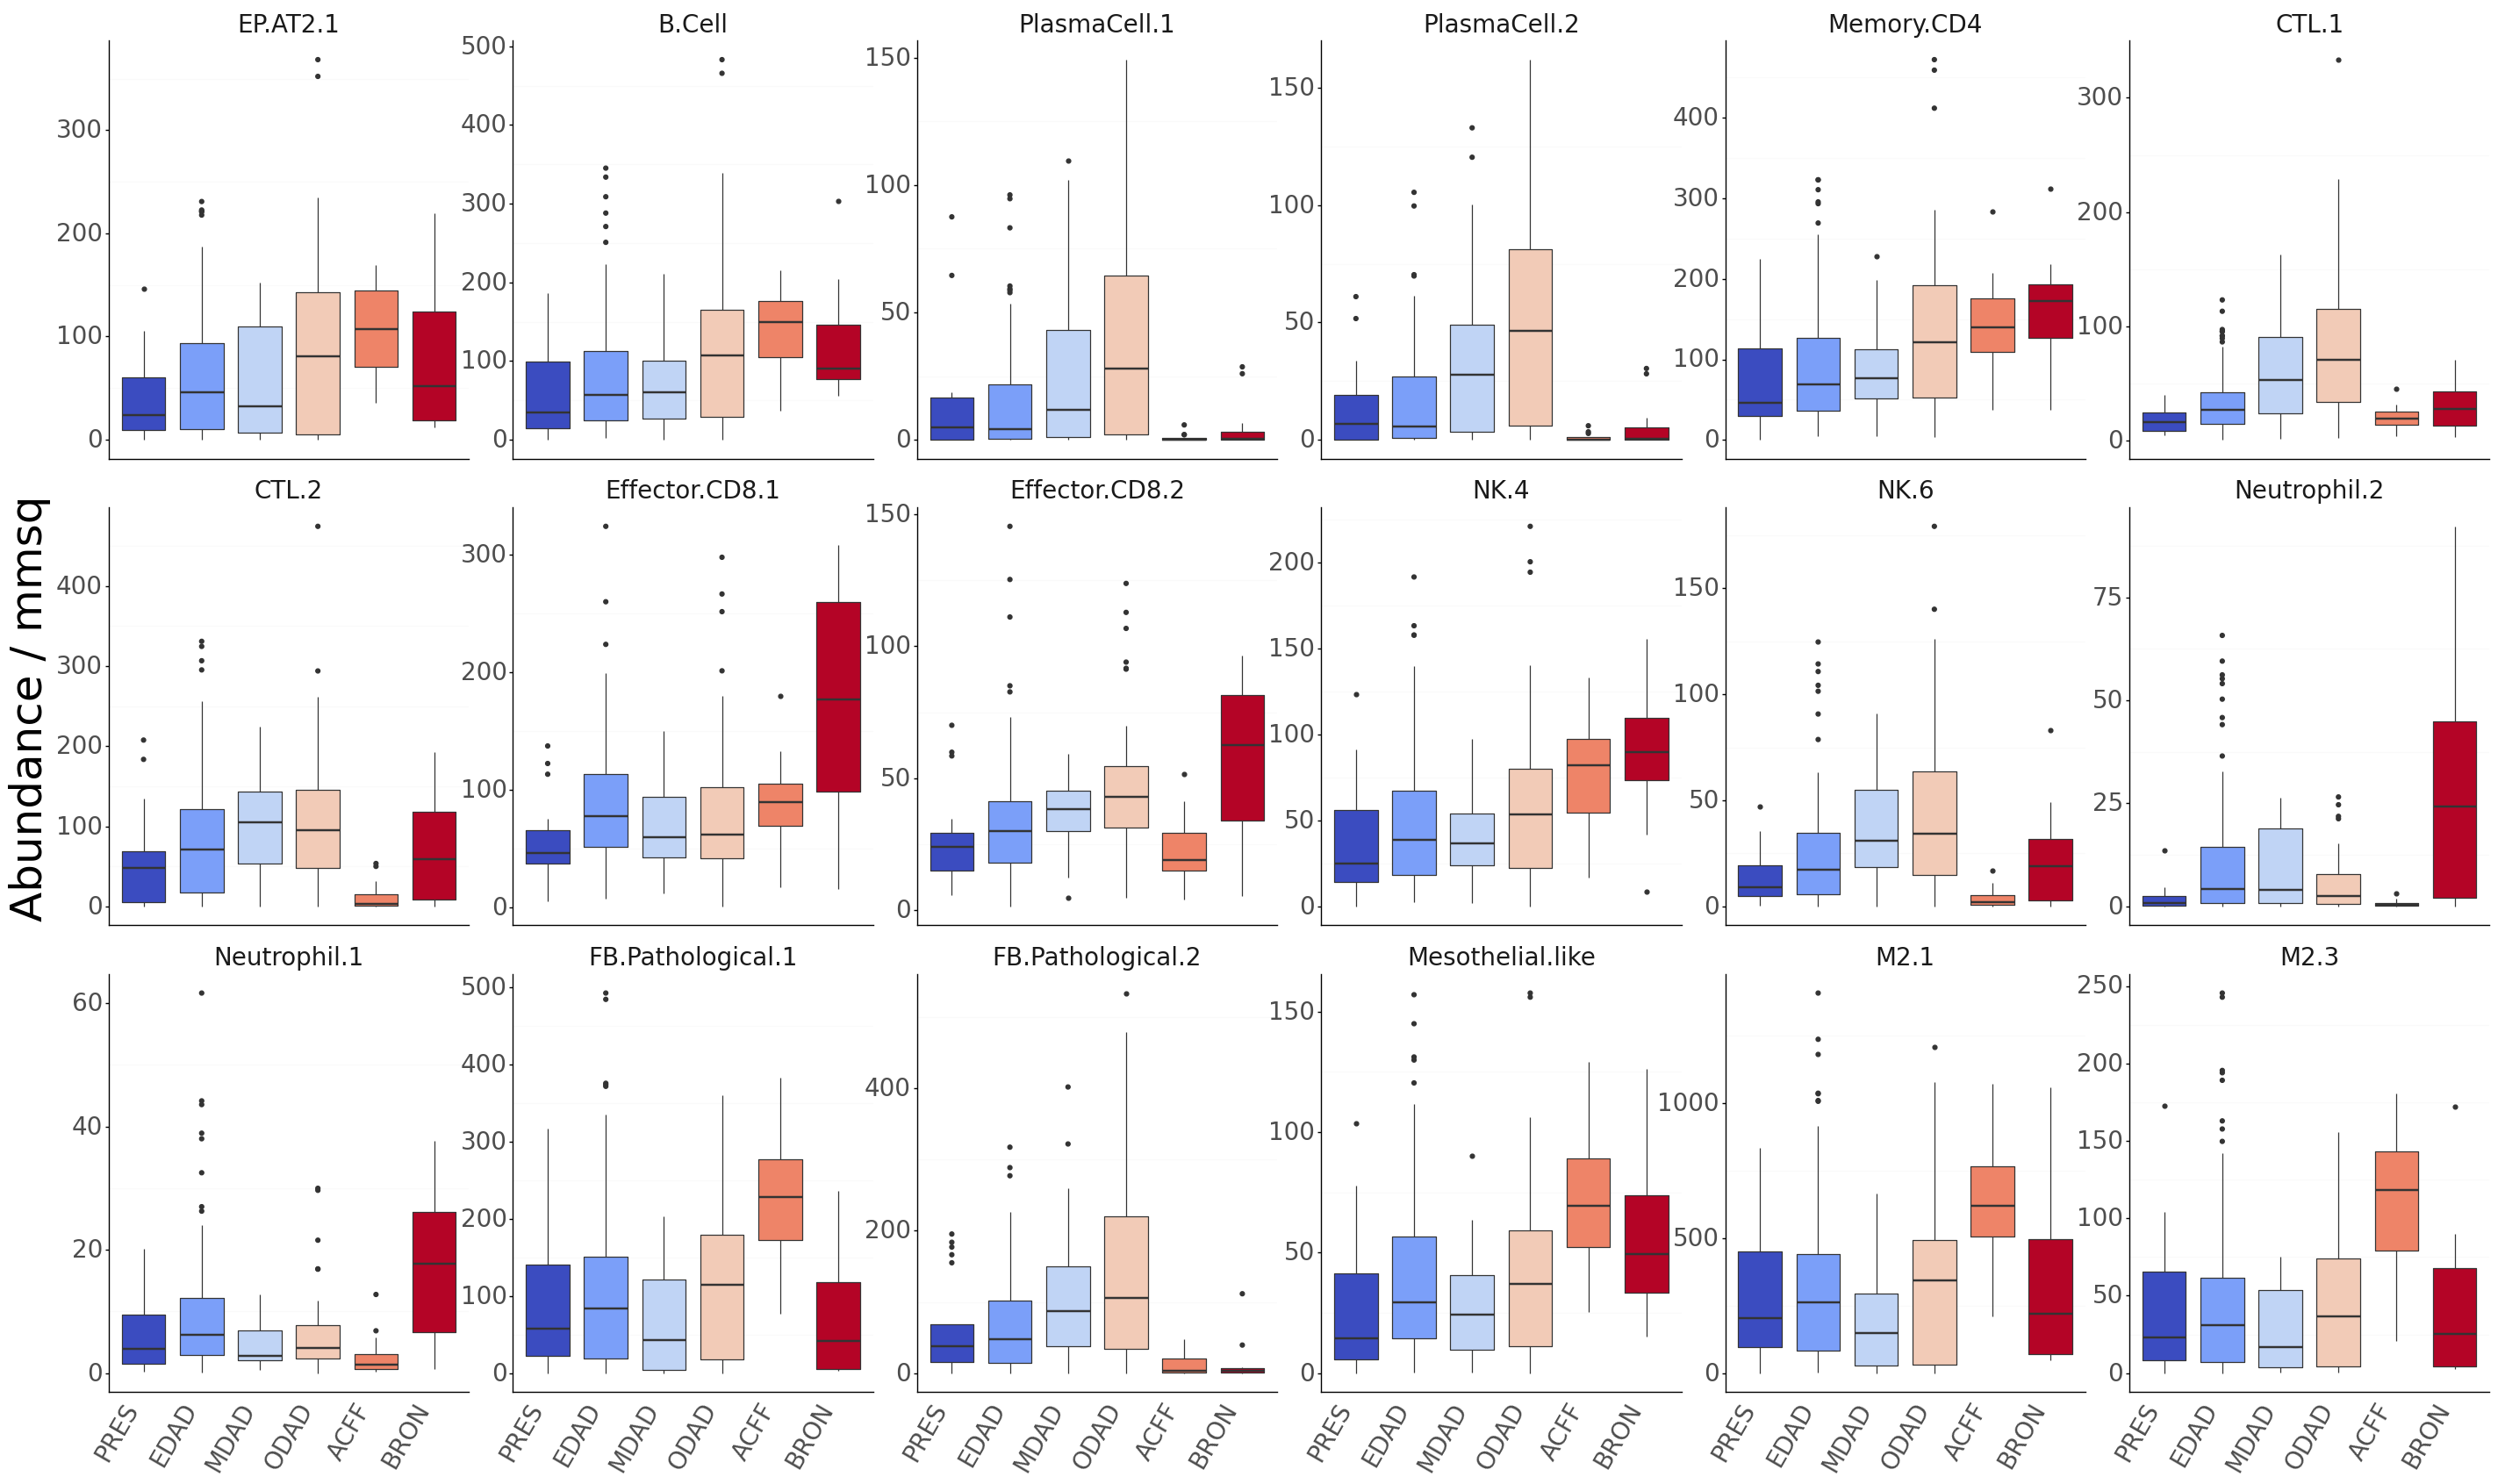

<ggplot: (8776030378205)>

In [13]:
plotnine.options.figure_size=(35,20)
plotnine.dpi = dpi

select_cell_type = ["AT2.1", "EC." "Neutrophil", "B.Cell", "PlasmaCell", "CD4", "CTL.1", "CTL.2", "CD8", "NK.4", "NK.6", "Neutrophil", "Pathological.1", "Pathological.2", "Mesothelial", "M2.1", "M2.3"]

plot_abundance_celltype = pd.DataFrame()

for cell_type in select_cell_type:
    plot_abundance_celltype = plot_abundance_celltype.append( abundance_df.abundance_df[ [ cell_type in c for c in abundance_df.abundance_df.Celltype ] ] )

plot_abundance_celltype.Celltype = pd.Categorical(plot_abundance_celltype.Celltype, ordered=True, categories=plot_abundance_celltype.Celltype.unique() )
    
p2 = (
    ggplot() + 
    geom_boxplot(data = plot_abundance_celltype, mapping = aes(x = "Background", y = "Abundance", fill = "Background") ) + 
    theme_bw() +
    theme(axis_text_x = element_text(angle = 60, vjust = 1, hjust=1, size=20),  
          axis_text_y = element_text(size=20),
          axis_title_x = element_blank(), 
          axis_title_y = element_text(size=36),
          axis_ticks_major_x = element_blank(),
          panel_grid_major_x = element_blank(),
          panel_grid_major_y = element_blank(),
          strip_background_x= element_blank(),
          strip_text_x=element_text(size = 20),
          panel_border = element_blank(),
          panel_spacing_x = .5,
          panel_spacing_y = .2,
          axis_line_x = element_line(),
          axis_line_y = element_line(),
          legend_position = "none" ) + 
    scale_x_discrete(limits = ["PRES", "EDAD", "MDAD", "ODAD", "ACFF", "BRON"]) +
    scale_fill_manual(breaks = ["PRES", "EDAD", "MDAD", "ODAD", "ACFF", "BRON"], values = [mpl.colors.rgb2hex(cm.get_cmap('coolwarm', 6)(c)) for c in range(6) ]) +
    facet_wrap(facets="~Celltype", scales="free_y", nrow = 3)  +
    ylab("Abundance / mmsq")
)

p2